# Adding data to watsonx.data Hive and Iceberg

## Import necessary libraries

In [ ]:
!pip install presto-python-client==0.8.4
!pip install PyHive==0.7.0
!pip install ibm-cos-sdk

In [ ]:
import os
import io
import pandas as pd

import prestodb
import ibm_boto3
from ibm_botocore.client import Config, ClientError

from dotenv import load_dotenv

## Load connections information from the project

In [ ]:
# list your connections
wslib.list_connections()

In [ ]:
# make sure you use the right connection name for presto
presto_conn = wslib.get_connection('ATT_Enablement_watsonx_data_presto')
cos_conn = wslib.get_connection('ATT_Enablement_cos_connection')

## Load env.txt file with configuration

In [ ]:
with open('.env_all', 'wb') as env_file:
    env_file.write(wslib.load_data('env.txt').read())
# environmental variables store credentials and configuration
load_dotenv('.env_all')

## Configuration and credentials
> for Presto watsonx.data and COS

In [ ]:
wxd_cred = {
    "password": presto_conn['api_key'],
    "engine_host": presto_conn['engine_host'],
    "ssl": """true""",
    "engine_port": presto_conn['engine_port'],
    "username": 'ibmlhapikey'
}

In [ ]:
# watsonx.data configuration
hive_catalog = os.environ["HIVE_CATALOG"]
schema_data_h = os.environ["SCHEMA_DATA_H"]

iceberg_catalog = os.environ["ICEBERG_CATALOG"]
schema_data_i = os.environ["SCHEMA_DATA_I"]

In [ ]:
# Constants for IBM COS values
COS_ENDPOINT = f"https://s3.ca-tor.cloud-object-storage.appdomain.cloud"
COS_API_KEY_ID = cos_conn['api_key']
COS_INSTANCE_CRN = cos_conn['resource_instance_id']
HIVE_BUCKET = os.environ["HIVE_BUCKET"]
WXD_BUCKET = os.environ["WXD_BUCKET"]

### make sure that COS_ENDPOINT is the same as for buckets and the same for all buckets, if not -> replace

In [ ]:
print(COS_ENDPOINT)
# COS_ENDPOINT = "enter https-prepended endpoint and uncomment"

In [ ]:
# file names
file_names = {
    "pq": ["accounts", "holdings_up_2023"],
    "json": ["tax_liability"]
}

## Connection
Connecting to Presto engine of watsonx.data and COS instance

### Presto watsonx.data

In [ ]:
conn = prestodb.dbapi.connect(
       host=wxd_cred['engine_host'],
       port=wxd_cred['engine_port'],
       user=wxd_cred['username'],
       http_scheme='https',
       auth=prestodb.auth.BasicAuthentication(wxd_cred['username'], wxd_cred['password'])
)
# cursor
cur = conn.cursor()

In [ ]:
# checking that cursor is working
cur.execute(f"SHOW schemas from {iceberg_catalog}")
rows = cur.fetchall()
rows

### COS Client

In [ ]:
# Create client
client = ibm_boto3.client("s3",
    ibm_api_key_id=COS_API_KEY_ID,
    ibm_service_instance_id=COS_INSTANCE_CRN,
    config=Config(signature_version="oauth"),
    endpoint_url=COS_ENDPOINT
)

## Helper functions
> will be used later during lab  
- to save parquet and json files to COS bucket
- to read parquet files from COS bucket
- to execurte sql statements on Presto engine

In [ ]:
def read_parquet_file(bucket_name: str, file_key: str) -> None:
    """
    Read parquet file from COS
    """
    try:
        body = client.get_object(Bucket=bucket_name, Key=file_key)['Body']
        df_pq = pd.read_parquet(io.BytesIO(body.read()))
        return df_pq
    except Exception as e:
        print("Unable to retrieve bucket contents: {0}".format(e))

def execute_sql_statements(presto_cursor: prestodb.dbapi.Connection.cursor, sql_scripts: dict) -> dict:
    """
    Execute SQL statements from the dictionary and return a dictionary of results.
    
    Args:
        presto_cursor (prestodb.dbapi.Connection.cursor): A Presto cursor object.
        sql_scripts (Dict[str, str]): A dictionary where keys are identifiers and values are SQL statements.
    
    Returns:
        Dict[str, List[Any]]: A dictionary mapping each SQL script identifier to its result rows.
    """
    results = {}
    try:
        for key, sql_script in sql_scripts.items():
            cur_script = sql_script.strip()
            presto_cursor.execute(cur_script)
            rows = cur.fetchall()
            print(f"{key} result is {rows}")
            results[key] = rows
    except Exception as e:
        print(f"Error: {e}")
    return results

## Input data available in watsonx.data hive bucket with input_data_hive prefix
* initial parquet files for accounts and holdings_2023 are available in COS `HIVE_BUCKET` 
 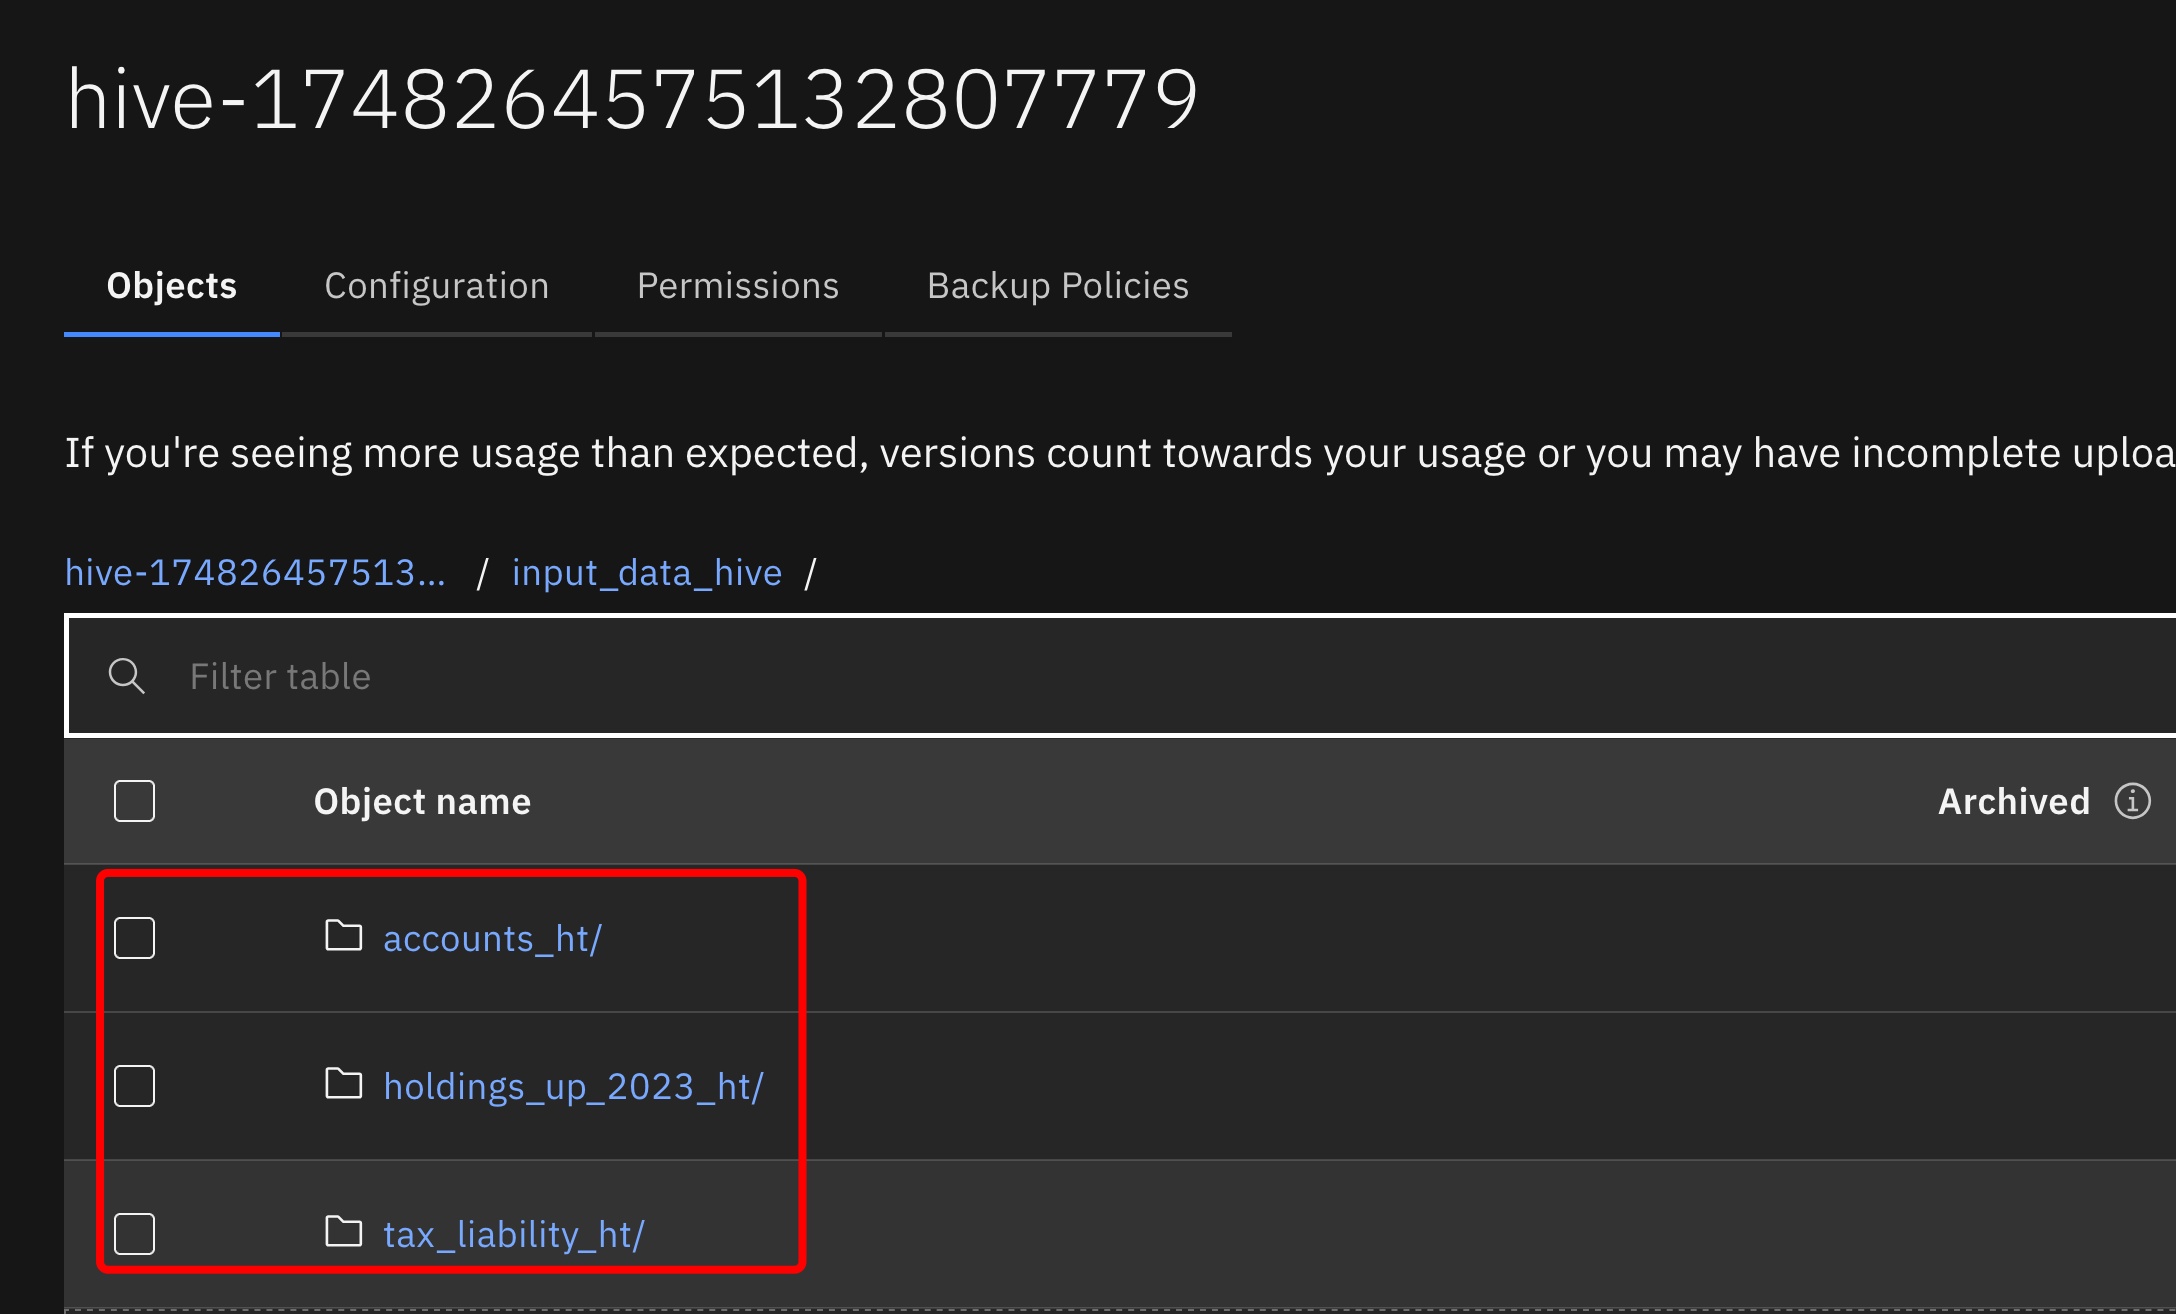
* `tax_liability` is saved in json format in COS `HIVE_BUCKET` to check working with different formats
* Link COS `HIVE_BUCKET` files as external tables to hive_catalog for `accounts`, `holdings_up_2023`, `tax_liability` tables based on the tables definitions

### Tables definitions for hive_catalog
in the format `{(table_name, fileformat):"table schema"}`

In [ ]:
tables_def = {
    ("accounts", "parquet"): """
    (
    customer_id INT,
    account_id INT
    )
""",
   ("holdings_up_2023", "parquet"): """
(
    holding_id CHAR(64),
    account_id INT,
    asset_ticker CHAR(3),
    holding_amt BIGINT,
    tax_liability DOUBLE
)
""",
   ("tax_liability", "json"): """
(
    country VARCHAR,
    tax_percentage DOUBLE
)
"""
}

### Check parquet files in `HIVE_BUCKET`

In [ ]:
for d_n in file_names['pq']:
    print(f'Content of {d_n} in {HIVE_BUCKET}')
    display(read_parquet_file(HIVE_BUCKET, f'input_data_hive/{d_n}_ht/{d_n}.parquet'))

### Linking files to hive as external tables
![](../attachments/2025-04-22-17-34-17-pasted-vscode.png)
1. Create `"input_data_hive_YourName_First3LettersOfSurname"` schema defined in `schema_data_h` var  in `hive_catalog`
2. First drop if exist and then create tables based on `tables_def` dictionary
3. Check that tables were created by calculating the number of rows

In [ ]:
sql_scripts_list = list()

sql_scripts_list.append({
    'sql_create_schema':
    f"""

create schema if not exists {hive_catalog}.{schema_data_h} with (location = 's3a://{HIVE_BUCKET}/{schema_data_h}/')
"""
}
)

for table_name, file_format in tables_def:
    sql_scripts_h = {}
    sql_scripts_h['sql_drop_table'] =f"""

    drop table if exists {hive_catalog}.{schema_data_h}.{table_name}_ht
    """

    sql_scripts_h['sql_create_table'] = f"""
    create table {hive_catalog}.{schema_data_h}.{table_name}_ht
    {tables_def[(table_name, file_format)]}
    with (format = '{file_format}',
    external_location='s3a://{HIVE_BUCKET}/input_data_hive/{table_name}_ht')
    """

    sql_scripts_h['check_number_rows'] = f"""
    SELECT count(*) FROM {hive_catalog}.{schema_data_h}.{table_name}_ht
    """

    sql_scripts_list.append(sql_scripts_h)

In [ ]:
for c_s in sql_scripts_list:
    execute_sql_statements(cur, c_s)

### Creating a table in iceberg catalog in wx.data for accounts table
![](../attachments/2025-04-22-17-35-11-pasted-vscode.png)
For accounts tables we will be saving it without transformations to `iceberg_data` catalog:
1. Create schema in iceberg_data catalog `iceberg_data."clients_schema_YourName_First3LettersOfSurname"`
2. Drop table `accounts_table` if exists
3. Create a new table in iceberg_data catalog / new schema based on `hive_catalog.input_data_hive.accounts_ht`
4. Count number of rows on a table to check that it exists


In [ ]:
table_name_i = 'accounts_table'
table_name_h = 'accounts_ht'

sql_scripts_i = {}
sql_scripts_i['sql_create_schema'] = f"""

create schema if not exists {iceberg_catalog}.{schema_data_i} with (location = 's3a://{WXD_BUCKET}/{schema_data_i}/')
"""

sql_scripts_i['sql_drop_table'] = f"""

drop table if exists {iceberg_catalog}.{schema_data_i}.{table_name_i}
"""
sql_scripts_i['sql_session'] = f"""

set session {hive_catalog}.parquet_use_column_names=true
"""

sql_scripts_i['sql_create_table'] = f"""
create table {iceberg_catalog}.{schema_data_i}.{table_name_i} as
select
    *
from 
   {hive_catalog}.{schema_data_h}.{table_name_h}
"""
sql_scripts_i['check_n_rows'] = f"""
SELECT count(*) FROM {iceberg_catalog}.{schema_data_i}.{table_name_i}
"""

In [ ]:
execute_sql_statements(cur, sql_scripts_i)